In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import time
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
sys.path.append("../dataprocess")
import dataprocess as dp

#### KPCA functions

In [18]:
def performKPCA(
    X_train: np.ndarray,
    r_max: int,
    kernel_fcn: str,
    gamma: float,
    degree: int,
    alpha: float,
    transpose_flag: bool,
):
    """Perform the Kernel PCA (KPCA) algorithm with scikit-learn

    Args:
        X_train (np.ndarray): data matrix
        r_max (int): number of components to keep in the latent space
        kernel_fcn (str): kernel function (rbf, sigmoid, linear, poly, cosine)
        gamma (float): parameter for rbf and sigmoid kernel
        degree (int): parameter for poly kernel
        alpha (float): regularization parameter
        transpose_flag (bool): temporal vs spatial arrangement of data

    Returns:
        X_kpca (KernelPCA): KPCA object
    """

    if not transpose_flag:
        """the scikit-learn algorithm by default has a different data
        arrangement than our definition above
        By default it will reduce the size of the rows,
        while our default is to reduce the size of the columns
        if True: temporal size of the data will be reduced (leading to spatial modes)
        -> RAM requirement very high!
        if False: spatial size of the data will be reduced (NOT leading to  spatial modes)
        """
        X_train = X_train.T

    start = time.time()
    # construct affinity matrix
    # compute nearest neighbors matrix
    kpca = KernelPCA(
        n_components=r_max,
        kernel=kernel_fcn,
        fit_inverse_transform=True,
        gamma=gamma,
        degree=degree,
        alpha=alpha,
    )

    X_kpca = kpca.fit(X_train)
    X_fit_transform = X_kpca.fit_transform(X_train)
    end = time.time()
    print("Time elapsed for kPCA:", end - start, " s")
    print("Shape after embedding:", X_kpca.eigenvectors_.shape)

    return X_kpca, X_fit_transform

In [19]:
def inverseTransform(
    X_train: np.ndarray,
    X_test: np.ndarray,
    r_max: int,
    r_step: int,
    kernel_fcn: str,
    gamma: float,
    degree: int,
    alpha: float,
    transpose_flag: bool,
):
    """Mapping back to the original space from the latent space and calculating reconstruction errors

    Args:
        X_train (np.ndarray): train data matrix
        X_test (np.ndarray): test data matrix
        r_max (int): max number of components used for reconstruction
        r_step (int): mode number increment for calculating the reconstruction error
        kernel_fcn (str): kernel function (rbf, sigmoid, linear, poly, cosine)
        gamma (float): parameter for rbf and sigmoid kernel
        degree (int): parameter for poly kernel
        alpha (float): regularization parameter
        transpose_flag (bool): temporal vs spatial arrangement of data

    Returns:
        X_reconstructed (np.ndarray): reconstructed data matrix with r_max modes
        err_rec (np.ndarray): vector containing the reconstruction error for 1 to r_max modes
    """

    err_rec = np.zeros(len(range(1, r_max + 1, r_step)))
    if not transpose_flag:
        # the scikit-learn algorithm by default has a different data arrangement than our definition above
        X_train = X_train.T
        X_test = X_test.T
    i = 0
    for r in range(1, r_max + 1, r_step):
        kpca = KernelPCA(
            n_components=r,
            kernel=kernel_fcn,
            fit_inverse_transform=True,
            gamma=gamma,
            degree=degree,
            alpha=alpha,
        )
        X_kpca = kpca.fit(X_train)
        X_test_transf = X_kpca.transform(X_test)
        X_reconstructed = kpca.inverse_transform(X_test_transf)

        # calculate reconstruction error over all snapshots using Frobenius norm
        err_rec[i] = np.linalg.norm(X_test - X_reconstructed) / np.linalg.norm(X_test)
        i += 1
    return X_reconstructed, err_rec

#### Parameters

In [20]:
# Mesh
nx = 227  # X-direction nodes
ny = 120  # Y-direction nodes
# Domain:
Lx = 17.665369  # Lx (Size of the box in x-direction)
Ly = 9.0  # Ly (Size of the box in y-direction)
# Cylinder coordinates:
X_0 = 2.66537  # X coordinate of the center
Y_0 = 4.5  # Y coordinate of the center
r = 0.5  # Cylinder radius

mesh = dp.Mesh(nx, ny, Lx, Ly, X_0, Y_0, r)

# Data path
re = 100
train_input_dir = "../data/modV_train"
test_input_dir = "../data/modV_test"
input_filename = f'modV_crop_re{re}.csv'
# Max number of components and step for postprocess
r_max = 12
r_step = 1

In [21]:
''' Read velocity data
  X - velocity module
 rows of X correspond to velocity components at spatial locations
 columns of X correspond to timesteps
     t_1 t_2.  .  t_n
 X = [u  u  .  .  .]  (x_1,y_1)
     [v  v  .  .  .]  (x_1,y_1)
     [w  w  .  .  .]  (x_1,y_1)
     [u  u  .  .  .]  (x_2,y_2)
     [v  v  .  .  .]  (x_2,y_2)
     [w  w  .  .  .]  (x_2,y_2)
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
'''
X_train = dp.read_X_csv(os.path.join(train_input_dir, input_filename))
X_test = dp.read_X_csv(os.path.join(train_input_dir, input_filename))

# Scale data
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

n, m = X_train.shape

print("Data matrix X is n by m:", n, "x", m, flush=True)

# Create mesh class instance
mesh = dp.Mesh(nx, ny, Lx, Ly, X_0, Y_0, r)
# Erase cylinder from snapshot
X_train_filt = dp.erase_cyl(X_train, mesh)
X_test_filt = dp.erase_cyl(X_test, mesh)

#### Perform KPCA

In [50]:
# transpose_flag - temporal vs spatial arrangement of data
#        if True: temporal size of the data will be reduced (leading to spatial modes)
#        if False: spatial size of the data will be reduced (NOT leading to spatial modes)
transpose_flag = False

# Kernel PCA w/ scikit learn
# choose kernel function, options: rbf, sigmoid, linear, poly, cosine
kernel_fcn = "rbf"
# gamma - parameter for rbf, sigmoid kernel
# degree - parameter for the poly kernel
# alpha - regularization parameter
gamma = 0.01
degree = 1
alpha = 1e-3

In [42]:
# save modes in csv and png files
save_flag = False
if save_flag:
    X_kpca = performKPCA(
        X_train_filt, r_max, kernel_fcn, gamma, degree, alpha, transpose_flag
    )
    outfile_dir = "modes/"
    modesToSave = r_max
    if modesToSave > X_kpca.eigenvectors_.shape[1]:
        modes = X_kpca.eigenvectors_.shape[1]
        print("Max number of modes is", X_kpca.eigenvectors_.shape[1])
    else:
        dp.save_modes(X_kpca, outfile_dir, modesToSave, mesh)

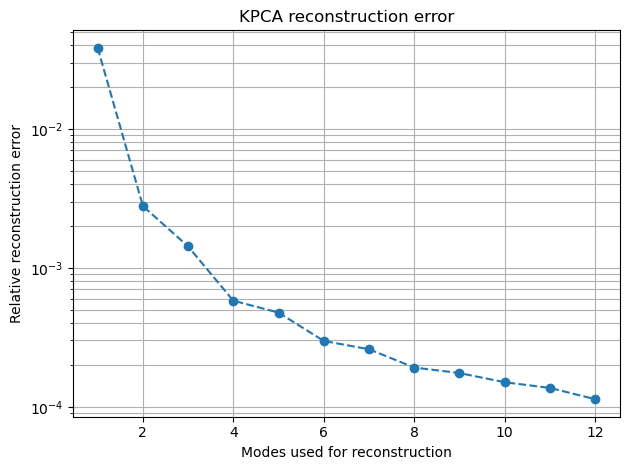

In [51]:
X_reconstructed, err_rec = inverseTransform(
    X_train_filt, X_test_filt, r_max, r_step, kernel_fcn, gamma, degree, alpha, transpose_flag
)
# Save reconstruction errors for further post-processing
np.savetxt("errorkPCAs.csv", err_rec, delimiter=",")
dp.plot_save_reconst(err_rec, r_max, r_step, "KPCA")